In [ ]:
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras import layers, models, optimizers
from keras.optimizers import adam, Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from skimage.transform import resize
%matplotlib inline
import matplotlib.pyplot as plt
from keras import initializers
from keras import backend as K
from keras.models import Model
from keras.layers import *
from urllib import request
import tensorflow as tf
from skimage import io
from lxml import etree
from PIL import Image
from keras import *
import numpy as np
import tarfile
import keras

import glob
import sys
import cv2
import os
import re


print("TensorFlow Version : ", tf.__version__)
print("Open CV Version : ",cv2.__version__)
print("Keras Version : ", keras.__version__)

Using TensorFlow backend.


TensorFlow Version :  2.2.0
Open CV Version :  4.1.2
Keras Version :  2.3.1


In [ ]:
#Here we mount the google drive to save our trained model weights
'''from google.colab import drive
drive.mount('/content/gdrive')'''

"from google.colab import drive\ndrive.mount('/content/gdrive')"

We download the PASCAL VOC 2009 dataset and save it into a local folder. The downloaded dataset is extracted into the folder **/content/sample_data/PascalVOC/**. As long as the runtime is connected, the data set will be present in the downloaded location and will be loaded into the variables. Once, the run-time gets disconnected or the Colab Notebook is closed, the dataset will be downloaded again and saved into the below mentioned folder.


In [ ]:
basePath = "/content/sample_data/PascalVOC/"

if not os.path.isdir(basePath):
  os.makedirs(basePath)

pascalVOCDataSetURL = "http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar"

if os.path.isfile(basePath+"VOCtrainval_11-May-2009.tar"):
  print("VOCtrainval_11-May-2009.tar already exists in the folder {}".format(basePath))
  if len(os.listdir(basePath+"VOCdevkit") ) == 0:
    print("Directory is empty")
    os.system("rm -rf /content/sample_data/VOCdevkit/")
    with tarfile.open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar")) as f:
      f.extractall(os.path.join(basePath))
  else:    
    print("Data sets are already downloaded and is present in the directory {}".format(basePath))

else:
  print("Downloading file VOCtrainval_11-May-2009.tar from {}".format(pascalVOCDataSetURL))
  print("This might take few minutes !!!")
  with request.urlopen(pascalVOCDataSetURL) as r, open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar"), 'wb') as f:
    f.write(r.read())
  print("Download Complete !!!")
  print("Extracting the data sets into the folder {}".format(basePath))
    # extract
  with tarfile.open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar")) as f:
    f.extractall(os.path.join(basePath))
  print("Data set extraction Complete !!!")

This might take few minutes !!!
Download Complete !!!
Extracting the data sets into the folder /content/sample_data/PascalVOC/
Data set extraction Complete !!!


In [ ]:
dataSetDirectory = basePath + "VOCdevkit/VOC2009/"
imgageDirectory = os.path.join(dataSetDirectory, 'JPEGImages')
annotationsDirectory = os.path.join(dataSetDirectory, 'Annotations')
segFolder = os.path.join(dataSetDirectory, 'ImageSets', 'Segmentation')
setDirectory = os.path.join(dataSetDirectory, 'ImageSets', 'Main')
annotationFiles = os.listdir(annotationsDirectory)
classesFiles = os.listdir(setDirectory)

For classification, we train the classifier on the images and the model gives the output in terms of confidence scores for each class. The input to this classifier will be a one-hot encoded vector of the labels. 

For segmentation, the models takes an image as input and outputs another image with segmented objects. Since, we are performing supervised learning, the target for a segmentation model is a segmented image with different colors. Each color is associated to a class of the object. Therefore, to train the segmentation model, it is necessary to encode the target image colors to its corresponding classes. The COLORMAP list shows the color values (RGB) for each class.

**Note:** Here the color palette for the boundary around a segmented object is not considered

In [ ]:
COLORMAP = [[0,0,0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


CM2CLASS = np.zeros(256 ** 3) # every pixel 0~255，RGB 3 channel

for i,cm in enumerate(COLORMAP):
    CM2CLASS[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i # build index

n_classes = len(CLASSES)
id2code = {k:v for k,v in enumerate(COLORMAP)}
image_size = 224

The data set images for each class are provided in a **.txt** file for training and validation images respectively. Rather than using the seperate **train.txt** and **val.txt** files, we load the complete data set using **trainval.txt** file. Every class has its own **trainval.txt**, therefore in the below cell we read all the files in on go. The dataset is later divided into train and test and validation sets from the full dataset. 

In [ ]:
txtFiles = [os.path.join(setDirectory, cf) for cls in CLASSES for cf in classesFiles if cls in cf and cls+'_trainval.txt' in cf] #List all the train files
txtFiles_segmentation = os.path.join(segFolder, 'trainval.txt')

In [ ]:
txtFiles

['/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/aeroplane_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/bicycle_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/bird_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/boat_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/bottle_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/bus_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/car_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/cat_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/chair_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/cow_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Main/diningtable_trainval.txt',
 '/content/sample_data/PascalVOC/VOCdevk

In [ ]:
txtFiles_segmentation

'/content/sample_data/PascalVOC/VOCdevkit/VOC2009/ImageSets/Segmentation/trainval.txt'

**Building Classification Dataset**

The below function reads the images of a class and returns the image dataset along with its labels for classification task. 

The images are loaded as numpy arrays of type float32. The corresponding labels are given out as one-hot encoded vectors.

**Note:** Reading and loading the images into can take sometime as we are loading the full dataset.

In [ ]:
def get_classification_dataset(list_of_files):
    """ build training or validation set
    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    for f_cf in list_of_files:
        with open(f_cf) as file: #It opens the files with all the names of the files with the pictures
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])

    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(basePath, "VOCdevkit/VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype('float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


In [ ]:
print("Data set loading is in progress. This can take a while. Please be patient !!!")
X_classifier, Y_classifier = get_classification_dataset(txtFiles)
print("Data set loading is complete !!!")

Data set loading is in progress. This can take a while. Please be patient !!!
Data set loading is complete !!!


In [ ]:
print('%i training images from %i classes' %(X_classifier.shape[0], Y_classifier.shape[1]))

10189 training images from 20 classes


The loaded image and label data sets for classification  has to be split into train and test sets. We use a factor of 0.15 to obtain the test set from the full dataset. Which means 85% of the full dataset is used for training and 15% will be used for testing. During training, the 85% of train data is further split into train and validation sets.

Here, we use a random seed so that the split datasets always have the same images. If this is not done, then the model performance keeps changing for each run as some images from train set can become a part of test set for a different run. The overall size of train and test sets for classifier is given in the below cell

In [ ]:
np.random.seed(21)
Xtrain_class, Xtest_class, Ytrain_class, Ytest_class = train_test_split(X_classifier,Y_classifier,test_size=0.15, random_state=21)
print("Classifier Training Images Size:", Xtrain_class.shape)
print("Classifier Training Labels Size:", Ytrain_class.shape)
print("Classifier Test Images Size:", Xtest_class.shape)
print("Classifier Test Labels Size:", Ytest_class.shape)

Classifier Training Images Size: (8660, 224, 224, 3)
Classifier Training Labels Size: (8660, 20)
Classifier Test Images Size: (1529, 224, 224, 3)
Classifier Test Labels Size: (1529, 20)


The data set is huge as takes a lot of memory. If the image size is increased, the variables can take up more memory. Continuing to use the notebook like this will eventually make it crash due to compelete usage of the RAM. Therefore, once, the images are loaded into train and test variables as arrays, we will  delete the full data set variables, so that the memory is freed again. 

In the below cell we delete the X and Y variables for the classification dataset.

In [ ]:
del X_classifier
del Y_classifier

Below we display some of the images and their labels

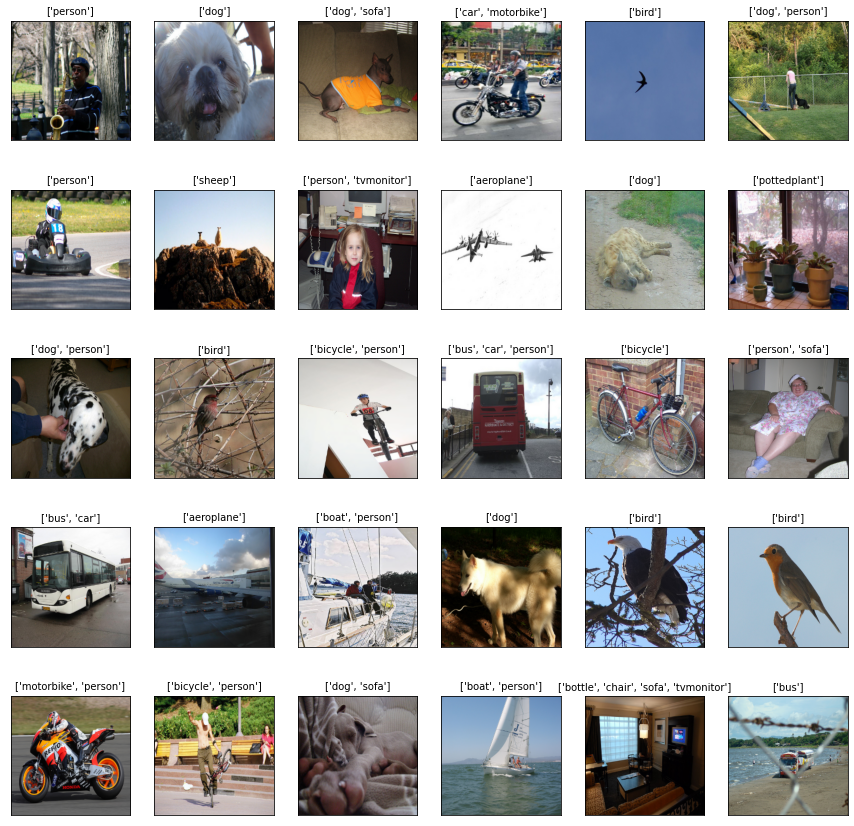

In [ ]:
fig, axes = plt.subplots(5,6, figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  str1 = [] 
  label = Ytrain_class[i] 
  ax.imshow(Xtrain_class[i])
  for idx, ele in enumerate(label):
    if ele > 0:
      str1.append(CLASSES[idx+1])
  ax.set_title("{}".format(str1), fontsize=10)

plt.show()

**Building Segmentation Dataset**

Similar to the classification data set, here we load the full segmentation data from **tranval.txt** files. The segmented labels are color mapped to the corresponding class label based on the color palette.

The below get_traget() function does the mapping of the color palette of labels to class ID's. 

In [ ]:
def get_target(img_path):
    """
     For segmentation task, read color image, transform it to 3-d one-hot encodeing class target image.
    :param img_path: the image path
    :return: target: (image_size,image_size,21)
    """
    label_im = Image.open(img_path).convert('RGB')
    im = label_im.resize((image_size, image_size), Image.ANTIALIAS)

    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    label_map =  np.array(CM2CLASS[idx], dtype='int64') # 2-d class map, class of every pixel

    return label_map

The below function labels2colors() maps the target images back to its original color palette.

**Note:** Since, we have not considered the color palette of the object boundaries, the mapping back will give a image without the boundary. 

In [ ]:
def labels2colors(labels, cmap):
    """
    Converts a matrix of labels (ie. pixels' semantic class) to an image with their equivalent color.
    :param labels: a matrix of class labels
    :param cmap: the color map, as a list of RGB tuples:
     - The first item is the background class color,
     - The last item is the color of the void/ignore class
    :return: an image with colorized pixels' class
    """
    labels_colored = np.zeros((*labels.shape, 3), dtype='uint8')
    for label in np.unique(labels):
        label_mask = labels == label
        label_mask = np.dot(np.expand_dims(label_mask, axis=2), np.array(cmap[label]).reshape((1, -1)))
        labels_colored += label_mask.astype('uint8')
    return labels_colored

In [ ]:
def get_segmentation_dataset(seg_file):
    with open(seg_file) as file:
        lines = file.read().splitlines()
        train_filter = [line.strip() for line in lines]

    image_folder = os.path.join(dataSetDirectory, "JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype('float32')

    seg_folder = os.path.join(dataSetDirectory, "SegmentationClass/")
    image_filenames = [os.path.join(seg_folder, file) for f in train_filter for file in os.listdir(seg_folder) if f in file]
    y = np.array([get_target(img_f) for img_f in image_filenames])

    return x, y


In [ ]:
print("Loading the segmentation dataset !!! Please be patient")
X_seg, Y_seg = get_segmentation_dataset(txtFiles_segmentation)
print("Loading the segmentation dataset is complete !!!")

Loading the segmentation dataset !!! Please be patient
Loading the segmentation dataset is complete !!!


Similar to the classification dataset, here we split the full segmentation data set into train and test  sets after seeding the random state. Since, the segmentation data set has less number of images compared to the classification dataset, we consider split the train set and test set to a factor of 0.1 which means, train set has 90% of images and the test set has 10%. The 90% train images are further split into train and validation sets during the model training.

In [ ]:
np.random.seed(12)
Xtrain_seg, Xtest_seg, Ytrain_seg, Ytest_seg = train_test_split(X_seg,Y_seg,test_size=0.1, random_state=12)
print("Segmentation Training Images Size:", Xtrain_seg.shape)
print("Segmentation Training Labels Size:", Ytrain_seg.shape)
print("Segmentation Test Images Size:", Xtest_seg.shape)
print("Segmentation Test Labels Size:", Ytest_seg.shape)

Segmentation Training Images Size: (1349, 224, 224, 3)
Segmentation Training Labels Size: (1349, 224, 224)
Segmentation Test Images Size: (150, 224, 224, 3)
Segmentation Test Labels Size: (150, 224, 224)


Here we delete the full data set variables to free the memory

In [ ]:
del X_seg
del Y_seg

The below function plot_seg_data_pairs() plots the original image and the corresponding segmentaion label. Here we randomly plot 5 different images and its labels

In [ ]:
def plot_seg_data_pairs(img, label):
  fig, ax = plt.subplots(figsize=(5, 5))
  plt.subplot(121)
  plt.imshow(img)
  plt.title("Image Feature")
  plt.subplot(122)
  plt.imshow(label)
  plt.title("Image Label")

  plt.show()

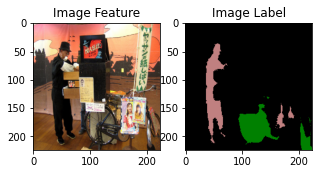

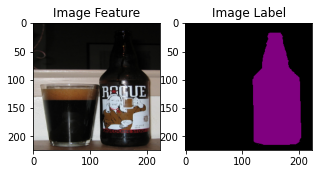

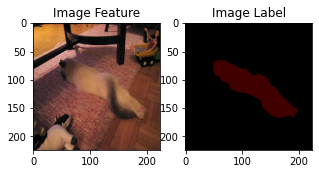

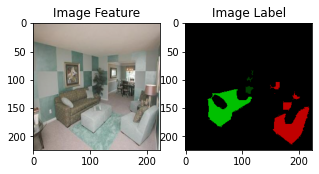

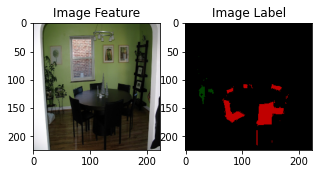

In [ ]:
for i in range(5):
  plot_seg_data_pairs(Xtrain_seg[i],labels2colors(Ytrain_seg[i],COLORMAP))

# 4 Supervised, end-to-end learning

**Parts of a CNN network**

**Convolutional layers**

Convolutional layers are unique in their functionality: it uses a kernel composed of weights of a certain size which is moved over the image with a certain 'stride' (often done for every seperate color channel of the image). After the input is passed through this layer, its output can be effectively interpreted as a convolved image (e.g. edge detector). Compared to dense layers the use of convolutional operations bypasses images being processed as a whole, which often does not agree with the nature of images where objects typically can be present in any any place within the image. It is also more robust towards problems arising from perspective, partial obstruction, ... etc. Typically a single layer extracts 'simple' patterns, stacking convolution layers extracts more complex patterns within the patterns.

**MaxPooling layers**

Mostly important for reducing computanial load and denoising purposes. Since typically an image has a lot of pixels as input and the associated neural net architectures are relatively deep (many layers), the amount of weight for the connections could easily become unwieldy and unfeasible fast. MaxPooling layers reduce this load by reducing the input size through extracting the largest pixel value from a chosen kernel size, and moving this kernel across the image with a certain stride. This can also be effective to filter out noise.

**Dense and flatten layers**

Dense layers are fully connected layers. In the context of CNN's these are typically used for the predictive part at the end of the network. The extracted information (= extracted features) from the images by the previous layers (= encoding part) are used as inputs. Since up to this point the processed input typically has a higher dimensional structure relevant for the encoding part but redundant at this point, a flattening opertion is typically applied making the extracted features a 1 dimensional input vector.

**Activation functions**

For image classification mostly ReLu is favored. This is because it has 3 main advantages over most functions:

*   Sparsity: any input smaller than zero produces a zero, eliminating faint responses (as opposed to continuous functions).
*   Vanishing gradient reduction: the gradient is more constant since the derivative of any input above 0 is always 1. This is more robust against pertubations in- or deflating the the gradient, resulting in a less 'noisy' gradient in the loss function. Especially relevant for deep architectures which are more sensitive to vanishing gradients or exploding gradients.
*   Computanial load reduction: The simple nature of the ReLu function reduces the computing load needed to evaluate the function.

This does not mean ReLu is without its own problems (non-top boundedness, dying ReLu problem, discontiunity in 0). 

For the last layer which predicts the class, a sigmoid is favored. This transforms the input into a value between 0 and 1 which can be interpreted as probabilities per class.

**Regularization**

To prevent an epoch altering the weights strongly and potentially pushing the model to an overfitted solution fast, a regularization constraint can be put on the weights. This is to prevent the network from taking too large learning steps for every epoch.

**Dropout layers**

During the training phase of a network, a percentage of randomly selected neurons of a chosen layer are deactivated. This diminishes co-depency among connections and aims to diminish overfitting. This also helps preventing overfitting by forcing the network to train randomly selected connections every time.

**Combining layers to form an net architecture**

As already mentioned above, dense layer(s) are relevant for the decoding part of the architecture. Other types of layers can follow in any order and both deep (many layers) and shallow can produce good results. By consequence, many architectures have emerged for image classification. Finding a fitting architecture for your problem involves tweaking known working architectures or iterating different 'educated guesses' of architectures. Some general rules for layer stacking exist but the amount of 'valid' architectures is potentially very diverse and large.

**Evaluating network performance**

*   Accuracy: fraction of model predictions which are correct. As a general indicator for overall quality usefull but sometimes more specific errors are usefull to monitor as well. In this case the image can potentially contain 20 classes but mostly contains around 1 to 3, meaning this number can be inflated when a model correctly predicts a lot of classes to be not present while not necessarily being able to predict the classes that ARE present, which is the end goal after all. More specific metrics will be more usefull to gauge the network performance in this case.

*   Precision: correct model predictions divided by correct model predictions and false positive model predictions. This fraction reflects if the network predicts a certain class is present how many times it is actually correct percentage-wise. In other words how precise are its positive predictions.

*   Recall: correct model predictions divided by correct model predictions and false negative model predictions. This fraction reflects for a certain class how many predictions were made correctly and how many times this class was not predicted to be present wrongly percentage-wise. This is sometimes called the sensitivity of the model.

*   F1 score: is the harmonic mean of precision and recall. This means that this score weights precision and recall equally.

**Loss function**

The desired optimization must be reflected using a mathematical expression which is to be minimized. It will be different for classification and segmentation.

**Training convergence**

Any model and especially potentially complex models like neural nets are prone to overfitting. So when evaluating accuracy overfitting must be explicitly considered as a constraint. The first base step to prevent this is achieved by splitting the data into training, validation sets and test sets. The model is 'trained' using the training data and validated using the validation data, where metrics for both datasets can be monitored. The model performance on the training data can overfit untill almost perfect accuracy while not being able to generate similar results for the validation data. Once the validation data performance metrics stop improving but the training data performance metrics keep improving it can be assumed that the model is starting to overfit the training data at this point. One 'flaw' with this reasoning that while the validation data is not directly used to train the model (optimizing the weight values) it is used to eventually determine the optimal parameters for its performance. It is undirectly used as a optimization criterion and thus can potentially also be prone to overfitting issues. For this reason a third set (test set) is usually considered, which is evaluated after the model weights are considered optimized to gauge if the generalization truly holds.

**Preprocessing steps**

The images are randomly split into training, validation and test sets motivated by the reasons mentoined above.

##4.1 Classification

The classification tasks that we perform here is a multi-label classification. This means that a image can have multiple labels. In multi-class classification, a data sample can belong to only one class(label). Whereas in multi-label classification, one data sample can belong to multiple classes (labels). 

The classifier model takes the input as images and one-hot encoded vector lables. Unlike a multi-class classifier network, the final layer of the model should be **sigmoid** rather than softmax because the final score for each class should be independent of each other. Sigmoid converts each score of the final hidden units between 0 to 1 independent of other scores.

The below image shows an example of the final layer of the multi-label classifier.
![alt text](https://miro.medium.com/max/1400/1*VgKMR74dhQi85kLx2zLC9Q.png)

If the sigmoid scores for a class is more than 0.5, then the data is classified into that class. And there could be multiple classes having a score of more than 0.5 independently. 

**Loss function**

Since we are using a sigmoid activation function and one-hot encoded target vectors,  we use binary_crossentropy loss for training.

[Image Source and Reference:] [Multi-Label Image Classification with Neural Network ](https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede)

###4.1.1 Classification end-end

In the above introduction section of classification, we have seen what activation and loss functions need to be used. Here we dicuss on what backbone architecture to be used for our classifier. 

For our use case we implement a VGG16 architecture from scracth. VGG16 is a convolution neural net (CNN ) that was first used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. 

Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. For our classifier the end layers are 1 FC(fully connected layers) followed by a sigmoid for output. The 16 in VGG16 refers to it has 16 layers that have weights.

The below image shows the VGG16 network architecture. Instead of softmax, we use a sigmod activation at the final FC layer for our classification task.

![VGG16 Network](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

[Image Source and Reference]: [Step by step VGG16 implementation in Keras for beginners]()

In [ ]:
def vgg16_model(nb_classes, input_height=224, input_width=224, hidden_dim=4096):
  model = Sequential()

  model.add(Conv2D(input_shape=(input_height,input_width,3),filters=64,kernel_size=(3,3),padding="same", activation="relu" , name='input'))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name='block1_conv2D_1'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='block1_maxpool2D_1')) 
  
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='block2_conv2D_1'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='block2_conv2D_2'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='block2_maxpool2D_1'))
  
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv2D_1'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv2D_2'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv2D_3'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='block3_maxpool2D_1'))
  
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv2D_1'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv2D_2'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv2D_3'))  
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='block4_maxpool2D_1'))
  
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv2D_1'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv2D_2'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv2D_3'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='block5_maxpool2D_1'))

  model.add(Flatten())

  model.add(Dense(units=hidden_dim,activation="relu", name='fc6'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(units=nb_classes, activation="sigmoid", name='fc7'))

  return model

The below cell initialized and loads the VGG16 model implemented above. We use the image size as 224x224x3 for training and 512 hidden units for hidden layer fc6.

In [ ]:
classifier_model_scratch =  vgg16_model(len(CLASSES)-1, image_size,image_size, 512)

The below summary shows the implemented VGG16 architecture. It can be seen that, it has 27,571,540 trainable parameters that the network has to learn from scratch using the traning images.

In [ ]:
classifier_model_scratch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2D_1 (Conv2D)     (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_maxpool2D_1 (MaxPooli (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv2D_1 (Conv2D)     (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2D_2 (Conv2D)     (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_maxpool2D_1 (MaxPooli (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv2D_1 (Conv2D)     (None, 56, 56, 256)      

In [ ]:
learning_rate = 0.0001
EPOCHS = 25

The evaluation metrics for a single class or multi label classifier can be accuracy as each data sample will have only one class, but for multi-label classifier, we use recall, precision and f1 scores.

Accuracy is straight forward and it deals with only the true positive as shown below.
![Accuracy](https://miro.medium.com/max/1026/1*JasZvEGWRoV7tsiovPK5QQ.png)

Accuracy will do a good job in the case of single or multi class, but for multi-label, we cannot compeletely rely on accuracy. We need to consider the true negative, false negatives as well. Therefore, we use the following metrices in evaluating the multi-label classifier.
Precision deals with the classification results with the actual results (TP and FP) where as recall deals with the true predictions with the predicted TP and FP. The recall and precision is as given below

![Pr-Re](https://miro.medium.com/max/1400/1*heeTAbWaKhxrGIwauXWbwA.png)

F1-score on the other hand uses both precision and recall as given below.  False positives and false negatives are crucial for a model evaluation, while true negatives are often less important to evaluate the model scores. The F1 score tries to take this into account, giving more weight to false negatives and false positives while not letting large numbers of true negatives influence the evaluation score.

![f1-score](https://miro.medium.com/max/1400/1*5_ZAlFhlCk8llhnYWD5PXw.png)

[Image Source and Reference:] [What’s the deal with Accuracy, Precision, Recall and F1?](https://towardsdatascience.com/whats-the-deal-with-accuracy-precision-recall-and-f1-f5d8b4db1021)


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

We then use a ADAM optimiser to optimize the network training and learning. The below call build the model with the optimizer, loss and the evaluation settings

In [ ]:
adam = keras.optimizers.Adam(lr=learning_rate,decay=learning_rate/EPOCHS)
classifier_model_scratch.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', f1_m, precision_m, recall_m])

The below cell trains our classifier with the training images and lables. Here, the parameter validation_split is used to split the train data set into train and validation sets. We use a batch size of 128 which means the model sees 128 images at a time for a epoch during training. Verbose = 1 makes the cell display the training process. Shuffle = True makes the model train on images on random order.

**Note:** The trained model weights are already saved and we don't neeed to train the model again. Therefore, the training process is commented. The model weights can be loaded and evaluated.

In [ ]:
classifier_model_history = classifier_model_scratch.fit(Xtrain_class, 
                                                        Ytrain_class, 
                                                        batch_size=128, 
                                                        validation_split=(0.15), 
                                                        epochs=EPOCHS, 
                                                        verbose=1, 
                                                        shuffle = True)

Train on 7361 samples, validate on 1299 samples
Epoch 1/25
7361/7361 [==============================] - 257s 35ms/step - loss: 0.6809 - accuracy: 0.5909 - f1_m: 0.2108 - precision_m: 0.1277 - recall_m: 0.6108 - val_loss: 0.6711 - val_accuracy: 0.9124 - val_f1_m: 0.3698 - val_precision_m: 0.5073 - val_recall_m: 0.2911
Epoch 2/25
7361/7361 [==============================] - 216s 29ms/step - loss: 0.6465 - accuracy: 0.7287 - f1_m: 0.2740 - precision_m: 0.1819 - recall_m: 0.5720 - val_loss: 0.6284 - val_accuracy: 0.9119 - val_f1_m: 0.3765 - val_precision_m: 0.5006 - val_recall_m: 0.3020
Epoch 3/25
7361/7361 [==============================] - 216s 29ms/step - loss: 0.5921 - accuracy: 0.8414 - f1_m: 0.3353 - precision_m: 0.2751 - recall_m: 0.4458 - val_loss: 0.5645 - val_accuracy: 0.9146 - val_f1_m: 0.3656 - val_precision_m: 0.5295 - val_recall_m: 0.2793
Epoch 4/25
7361/7361 [==============================] - 216s 29ms/step - loss: 0.5212 - accuracy: 0.8974 - f1_m: 0.3685 - precision_m: 0.42

In [ ]:
if os.path.isfile('Classification_FromScratch_Weights.h5'):
  print("Weights File exits !!! \n Loading Weights to the model")
  classifier_model_scratch.load_weights('Classification_FromScratch_Weights.h5')
else:
  print("Cannot find Weights !! Please re-upload the weights using the upload button in colab ")



Cannot find Weights !! Please re-upload the weights using the upload button in colab 


Here, we plot the training curvers for the metrices and losses.

In [ ]:
'''for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
    plt.plot(classifier_model_history.history[key],label=key)
plt.legend()
plt.show()

for key in ['f1_m', 'precision_m', 'recall_m','val_f1_m', 'val_precision_m', 'val_recall_m' ]:
    plt.plot(classifier_model_history.history[key],label=key)
plt.legend()
plt.show()'''

"for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:\n    plt.plot(classifier_model_history.history[key],label=key)\nplt.legend()\nplt.show()\n\nfor key in ['f1_m', 'precision_m', 'recall_m','val_f1_m', 'val_precision_m', 'val_recall_m' ]:\n    plt.plot(classifier_model_history.history[key],label=key)\nplt.legend()\nplt.show()"

We then evaluate the trained model on the test set. Since, we have trained the model from scratch, the model gives an training accuracy of 81% which is rather hight compared to other evaluation metrices like f1 score and precision. This is because our dataset is imbalanced.


We have already seen that, the person class has more number of images than any other class and sheep has the least number of images. Due to the imbalance in the dataset, the overall accuracy of model is high as it consideres only the true positives. Whereas the right way of evaluation is using the other metrices and their scores shows that the model has over all performance of the model is not thay great. 

In [ ]:
scores = classifier_model_scratch.evaluate(Xtest_class,Ytest_class)
print("Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[0], scores[0]*100))
print("Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[1], scores[1]*100))
print("Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[2], scores[2]*100))
print("Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[3], scores[3]*100))

1529/1529 [==============================] - 19s 12ms/step
Test set loss: 17.46%
Test set accuracy: 94.82%
Test set f1_m: 73.11%
Test set precision_m: 67.95%


In [ ]:
'''save_classification_scratch_model_name = 'Classification_FromScratch_Weights.h5'
classifier_model_scratch.save_weights('/content/gdrive/My Drive/'+save_classification_scratch_model_name)'''

"save_classification_scratch_model_name = 'Classification_FromScratch_Weights.h5'\nclassifier_model_scratch.save_weights('/content/gdrive/My Drive/'+save_classification_scratch_model_name)"

We save the model weights of the classifier trained from scratch and then predict the model output on the unseen test set. Some of the predictions of the classifier is shown in below figure

In [ ]:
y_pred_classifier_scratch = classifier_model_scratch.predict(Xtest_class)

In [ ]:
fig, axes = plt.subplots(15,4, figsize=(80,100), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  str1 = []  
  str2 = []
  for idx, ele in enumerate(Ytest_class[i]):
    if ele > 0:
      str1.append(CLASSES[idx+1])

  idx2 = np.argsort(y_pred_classifier_scratch[i])[::-1][:len(str1)]
  for ix in idx2:
    str2.append(CLASSES[ix+1])
  ax.imshow(Xtest_class[i])
  ax.set_title("gt: {}, pred: {}".format(str1,str2), fontsize=30)

plt.show()

In [ ]:
y_pred_class_arr = []
for y_pred_data in y_pred_classifier_scratch:
  y_pred_class = []
  for ele in y_pred_data:
    if ele > 0.4:
      y_pred_class.append(1)
    else:
      y_pred_class.append(0)
  y_pred_class_arr.append(y_pred_class)

y_pred_class_arr = np.array(y_pred_class_arr)



Here, we then calculate the confusion matrix for the model on the test set for each of the class. The below figure shows the confusion matrix. 

**Confusion Matrix:**

![confusion matrix](https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png)

**Observation:** From the results it can be seen that most of the classes have false negatives and false positives. It is due to the imbalanced classes in the dataset. 


In [ ]:
conusion_matrix_class_sratch = multilabel_confusion_matrix(y_pred_class_arr, Ytest_class)

for idx, conf_matrix in enumerate(conusion_matrix_class_sratch):
  print("Class: --> {} <-- and its Confusion Matrix : ".format(CLASSES[idx+1]))
  print(conf_matrix)
  print("\n")

Class: --> aeroplane <-- and its Confusion Matrix : 
[[1441   22]
 [  21   45]]


Class: --> bicycle <-- and its Confusion Matrix : 
[[1402   28]
 [  23   76]]


Class: --> bird <-- and its Confusion Matrix : 
[[1284   34]
 [ 164   47]]


Class: --> boat <-- and its Confusion Matrix : 
[[1383   13]
 [  73   60]]


Class: --> bottle <-- and its Confusion Matrix : 
[[1248   23]
 [ 156  102]]


Class: --> bus <-- and its Confusion Matrix : 
[[1390    4]
 [  66   69]]


Class: --> car <-- and its Confusion Matrix : 
[[1104   26]
 [ 200  199]]


Class: --> cat <-- and its Confusion Matrix : 
[[1403   46]
 [  30   50]]


Class: --> chair <-- and its Confusion Matrix : 
[[1242   44]
 [  34  209]]


Class: --> cow <-- and its Confusion Matrix : 
[[1501   26]
 [   1    1]]


Class: --> diningtable <-- and its Confusion Matrix : 
[[1397   17]
 [  14  101]]


Class: --> dog <-- and its Confusion Matrix : 
[[1387   54]
 [  18   70]]


Class: --> horse <-- and its Confusion Matrix : 
[[1435   25]
 

###4.1.2 Classification using Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets. Transfer learning is an approach to solve a deep learning problem that focuses on applying a stored knowledge of a problem to solve a different but related problem.

Transfer learning is flexible. It is a short-cut to re-use the model weights from pre-trained models directly, as a method of feature extraction preprocessing, and can be easily integrated into entirely new models.
Top performing models can be downloaded and used directly, or integrated into a new model for any computer vision problems.


###**Traditional Learning Vs Transfer Learning:**

*   Traditional learning is isolated and occurs purely based on specific tasks, datasets and training separate isolated models on them. No knowledge is retained which can be transferred from one model to another.
*   Whereas in transfer learning, you can leverage knowledge such as features, weights etc., from previously trained models for training newer models. It is highly useful to tackle problems where there is less data for a newer task




We compare our trained classifier from scratch with a classifier trained using transfer learning. Therefore, similar to the above model we use a VGG16 backbone for this task. Here we load the imagenet weights to the VGG16 layers and freeze the network layers. We only train the final layers of the model and then evaluate the perfromance on the test set.

In [ ]:
from keras.applications.vgg16 import VGG16
#load VGG16 model with weights from keras library
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In the below cell, we freeze the layers of the VGG16 with imagenet weights. We load the VGG model without the top layer. We then add the final FC (fully connected) layers as per our task requirement. In the below model summary it can be seen the the number of trainable parameters becomes lesser than the total parameters. This is due to the freezing of network layer with the weights.

In [ ]:
for layer in vgg_model.layers[:-1]:
    layer.trainable = False

In [ ]:
nb_class = len(CLASSES)-1
hidden_dim = 512

classifier_tl_model = models.Sequential()
classifier_tl_model.add(vgg_model)
classifier_tl_model.add(Flatten())
classifier_tl_model.add(Dense(hidden_dim, activation='relu', name='fc6'))
classifier_tl_model.add(BatchNormalization())
'''customVGGModel.add(Dense(hidden_dim, activation='relu', name='fc7'))
customVGGModel.add(BatchNormalization())'''
classifier_tl_model.add(Dropout(0.5))
classifier_tl_model.add(Dense(nb_class, activation='sigmoid', name='fc8'))

classifier_tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc6 (Dense)                  (None, 512)               12845568  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc8 (Dense)                  (None, 20)                10260     
Total params: 27,572,564
Trainable params: 12,856,852
Non-trainable params: 14,715,712
_________________________________

We use the same evaluation metrices and optimizers as above from the scratch model

In [ ]:
adam = keras.optimizers.Adam(lr=learning_rate,decay=learning_rate/EPOCHS)
classifier_tl_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
if os.path.isfile('Classification_TransferLearning_Weights.h5'):
  print("Weights File exits !!! \n Loading Weights to the model")
  classifier_tl_model.load_weights('Classification_TransferLearning_Weights.h5')
else:
  print("Cannot find Weights !! Please re-upload the weights using the upload button in colab ")

Cannot find Weights !! Please re-upload the weights using the upload button in colab 


We then train the classifer model with similar settings as that of the above from the scratch model. Since the initial layers are forzen, this model takes even lesser time for training compared to the above model. Also, the model performance and the metrices are better than the above from the scratch model. 

In [ ]:
classifier_tl_model_history = classifier_tl_model.fit(Xtrain_class, 
                                                        Ytrain_class, 
                                                        batch_size=128, 
                                                        validation_split=(0.15), 
                                                        epochs=EPOCHS, 
                                                        verbose=1, 
                                                        shuffle = True)

Train on 7361 samples, validate on 1299 samples
Epoch 1/25
7361/7361 [==============================] - 78s 11ms/step - loss: 0.8134 - accuracy: 0.5541 - f1_m: 0.2267 - precision_m: 0.1340 - recall_m: 0.7384 - val_loss: 0.6226 - val_accuracy: 0.6645 - val_f1_m: 0.2940 - val_precision_m: 0.1803 - val_recall_m: 0.7956
Epoch 2/25
7361/7361 [==============================] - 77s 10ms/step - loss: 0.7072 - accuracy: 0.6026 - f1_m: 0.2751 - precision_m: 0.1640 - recall_m: 0.8530 - val_loss: 0.6159 - val_accuracy: 0.6617 - val_f1_m: 0.3156 - val_precision_m: 0.1919 - val_recall_m: 0.8897
Epoch 3/25
7361/7361 [==============================] - 77s 10ms/step - loss: 0.6565 - accuracy: 0.6344 - f1_m: 0.2998 - precision_m: 0.1806 - recall_m: 0.8842 - val_loss: 0.6011 - val_accuracy: 0.6727 - val_f1_m: 0.3307 - val_precision_m: 0.2018 - val_recall_m: 0.9163
Epoch 4/25
7361/7361 [==============================] - 77s 10ms/step - loss: 0.6057 - accuracy: 0.6731 - f1_m: 0.3283 - precision_m: 0.2007 -

In [ ]:
'''for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
    plt.plot(classifier_tl_model_history.history[key],label=key)
plt.legend()
plt.show()

for key in ['f1_m', 'precision_m', 'recall_m','val_f1_m', 'val_precision_m', 'val_recall_m' ]:
    plt.plot(classifier_tl_model_history.history[key],label=key)
plt.legend()
plt.show()'''

"for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:\n    plt.plot(classifier_tl_model_history.history[key],label=key)\nplt.legend()\nplt.show()\n\nfor key in ['f1_m', 'precision_m', 'recall_m','val_f1_m', 'val_precision_m', 'val_recall_m' ]:\n    plt.plot(classifier_tl_model_history.history[key],label=key)\nplt.legend()\nplt.show()"

Here, we can see the model performs amazingly well with the pre-trained weights. The over all performance is very high compared to the from the scratch model.

In [ ]:
scores_tl = classifier_tl_model.evaluate(Xtest_class,Ytest_class)
print("Test set %s: %.2f%%" % (classifier_tl_model.metrics_names[0], scores_tl[0]*100))
print("Test set %s: %.2f%%" % (classifier_tl_model.metrics_names[1], scores_tl[1]*100))
print("Test set %s: %.2f%%" % (classifier_tl_model.metrics_names[2], scores_tl[2]*100))
print("Test set %s: %.2f%%" % (classifier_tl_model.metrics_names[3], scores_tl[3]*100))


1529/1529 [==============================] - 14s 9ms/step
Test set loss: 8.67%
Test set accuracy: 97.62%
Test set f1_m: 85.37%
Test set precision_m: 92.13%


In [ ]:
'''save_classification_tl_model_name = 'Classification_TransferLearning_Weights.h5'
classifier_tl_model.save_weights('/content/gdrive/My Drive/'+save_classification_tl_model_name)'''

"save_classification_tl_model_name = 'Classification_TransferLearning_Weights.h5'\nclassifier_tl_model.save_weights('/content/gdrive/My Drive/'+save_classification_tl_model_name)"

We then save the transfer learning weights and plot some of the predicted model outputs in the below figure.

In [ ]:
y_pred_classifier_tl = classifier_tl_model.predict(Xtest_class)

In [ ]:
fig, axes = plt.subplots(15,4, figsize=(80,100), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  str1 = []  
  str2 = []
  for idx, ele in enumerate(Ytest_class[i]):
    if ele > 0:
      str1.append(CLASSES[idx+1])

  idx2 = np.argsort(y_pred_classifier_tl[i])[::-1][:len(str1)]
  for ix in idx2:
    str2.append(CLASSES[ix+1])
  ax.imshow(Xtest_class[i])
  ax.set_title("gt: {}, pred: {}".format(str1,str2), fontsize=30)

plt.show()

In [ ]:
y_pred_tl_arr = []
for y_pred_data in y_pred_classifier_tl:
  y_pred_class = []
  for ele in y_pred_data:
    if ele > 0.4:
      y_pred_class.append(1)
    else:
      y_pred_class.append(0)
  y_pred_tl_arr.append(y_pred_class)

y_pred_tl_arr = np.array(y_pred_tl_arr)

The confusion matrix shows that the model performs better for most of the classes. The dataset is still imbalance but the model does a good job in reducing the number of false positives and false negatives for few classes like **aeroplane, bird, sofa and motorbike**.

In [ ]:
conusion_matrix_class_sratch = multilabel_confusion_matrix(y_pred_class_arr, Ytest_class)

for idx, conf_matrix in enumerate(conusion_matrix_class_sratch):
  print("Class: --> {} <-- and its Confusion Matrix : ".format(CLASSES[idx+1]))
  print(conf_matrix)
  print("\n")

Class: --> aeroplane <-- and its Confusion Matrix : 
[[1441   22]
 [  21   45]]


Class: --> bicycle <-- and its Confusion Matrix : 
[[1402   28]
 [  23   76]]


Class: --> bird <-- and its Confusion Matrix : 
[[1284   34]
 [ 164   47]]


Class: --> boat <-- and its Confusion Matrix : 
[[1383   13]
 [  73   60]]


Class: --> bottle <-- and its Confusion Matrix : 
[[1248   23]
 [ 156  102]]


Class: --> bus <-- and its Confusion Matrix : 
[[1390    4]
 [  66   69]]


Class: --> car <-- and its Confusion Matrix : 
[[1104   26]
 [ 200  199]]


Class: --> cat <-- and its Confusion Matrix : 
[[1403   46]
 [  30   50]]


Class: --> chair <-- and its Confusion Matrix : 
[[1242   44]
 [  34  209]]


Class: --> cow <-- and its Confusion Matrix : 
[[1501   26]
 [   1    1]]


Class: --> diningtable <-- and its Confusion Matrix : 
[[1397   17]
 [  14  101]]


Class: --> dog <-- and its Confusion Matrix : 
[[1387   54]
 [  18   70]]


Class: --> horse <-- and its Confusion Matrix : 
[[1435   25]
 

##4.2 Semantic Segmentation
Classification is a task where an image is classified based on the object in it. Object detection is a task where the object in a image is classified based on the bounding boxes surrounding it. The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. 

Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction. Note that unlike the previous tasks, the expected output in semantic segmentation are not just labels. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. 

Thus it is a pixel level image classification.

For our task, we use a UNet architecture with VGG backbone for training the segmentation model. Just like the classification model, we train the segmentation models as well from scratch and using transfer learning techniques. 

###4.2.1 Semantic Segmentation end-to-end

The UNET architecture contains two paths. First path is the called as the encoder which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path called as the decoder which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

The UNet architecture is as follows

![Unet](https://miro.medium.com/max/1400/1*OkUrpDD6I0FpugA_bbYBJQ.png)

The network uses something called as skip connections.  It means skipping some layers in the neural network and feeding the output of one layer to another layer skipping a few layers in between. Usually, some information is captured in the initial layers and is required for reconstruction during the up-sampling done using the fully connected network layer. An information that we have in the primary layers can be fed explicitly to the later layers using the skip architecture.

Skip connections also help traverse information faster in deep neural networks. Gradient information can get lost as we pass through multiple layers as we have problems of vanishing gradient descent. Advantages of skip connection are they pass information to lower layers so using it to classify minute details becomes easier.

Here in our architecture we use the skip connections as well.


[Image Source and Reference :] [Understanding Semantic Segmentation with UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

In [ ]:
def vggEncoder(input_height=image_size,  input_width=image_size):
  img_input = Input(shape=(input_height, input_width, 3))
  x = Conv2D(input_shape=(224,224,3),filters=64, name='block1_conv2D_1',kernel_size=(3,3),padding="same", activation="relu")(img_input)
  x = Conv2D(filters=64,kernel_size=(3,3),name='block1_conv2D_2', padding="same", activation="relu")(x)
  f1 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='block1_maxpool_2D')(x)

  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", name='block2_conv2D_1', activation="relu")(x)
  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", name='block2_conv2D_2',activation="relu")(x)
  f2 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block2_maxpool_2D')(x)
  
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_1',padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_2',padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_3',padding="same", activation="relu")(x)
  f3 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='block3_maxpool_2D')(x)
  
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_1', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_2', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_3', padding="same", activation="relu")(x)
  f4 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block4_maxpool_2D')(x)
  
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_1', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_2', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_3', padding="same", activation="relu")(x)
  f5 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block5_maxpool_2D' )(x)

  return img_input, x , [f1, f2, f3, f4, f5]

As said above, the below functions implement the encoder and decoder blocks of the UNet architecture. Since, the output of the model should be an image, the activation here is **he_normal** rather than a sigmoid or softmax. Also, we use some skip connections as discussed above that can be seen in the below architecture.

In [ ]:
def unetDecoderBlock(filter,input,concat,concat_encoder):
    up_conv = BatchNormalization()(Conv2D(filters=filter,kernel_size=(2,2),activation='relu',padding='same',
                                          kernel_initializer='he_normal')(UpSampling2D(size=(2,2),interpolation='bilinear')(input)))
    if concat:
        merge = concatenate([concat_encoder,up_conv])
    else:
        merge = up_conv
    conv1 = BatchNormalization()(Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',
                                        kernel_initializer='he_normal')(merge))
    conv2 = BatchNormalization()(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same',
                                        kernel_initializer='he_normal')(conv1))

    return conv2

In [ ]:
def unet(n_classes, input_height=image_size, input_width=image_size):
  img_input, vggOut, filters = vggEncoder(input_height=input_height, input_width=input_width)
  [ftr1, ftr2, ftr3, ftr4, ftr5] = filters

  conv1 = Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(vggOut)
  conv2 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
  decoder_input = Dropout(0.5)(conv2)

  decoder1 = unetDecoderBlock(filter=512,input=decoder_input,concat_encoder = ftr5, concat=True)
  decoder2 = unetDecoderBlock(filter=256,input=decoder1,concat_encoder = ftr4, concat=True)
  decoder3 = unetDecoderBlock(filter=128,input=decoder2,concat_encoder = ftr3,concat=True)
  decoder4 = unetDecoderBlock(filter=64,input=decoder3,concat_encoder = ftr2,concat=True)
  decoder5 = unetDecoderBlock(filter=64, input=decoder4, concat_encoder = ftr1, concat=False)

  Out =  Conv2D(filters=n_classes,kernel_size=(1,1),activation='relu',padding='same',
                    kernel_initializer='he_normal',name='seg_output')(decoder5)
  unetModelOut = Model(img_input, Out)

  return unetModelOut

In [ ]:
learning_rate_seg = 0.0001
EPOCHS_seg = 75
smooth = 1

Unlike the traditional loss functions, we use Dice loss defined Dice=2|A∩B||A|+|B|. The dice loss is calculated based on the overlap values of two functions whihc makes it suitable for our use case.

Another loss function that can be used is softmax cross entropy loss that deals with functions based on the maximum cross entropy. 

**Note:** After trying out multiple losses, we use dice loss for our task as it gives better results

In [ ]:
def dice_coef(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    y_true = K.one_hot(tf.compat.v1.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1])
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [ ]:
def softmax_sparse_crossentropy(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.compat.v1.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1])
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean

In [ ]:
unet_seg_scratch_model = unet(n_classes, input_height=image_size, input_width=image_size)

In [ ]:
unet_seg_scratch_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv2D_1 (Conv2D)        (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2D_2 (Conv2D)        (None, 224, 224, 64) 36928       block1_conv2D_1[0][0]            
__________________________________________________________________________________________________
block1_maxpool_2D (MaxPooling2D (None, 112, 112, 64) 0           block1_conv2D_2[0][0]            
____________________________________________________________________________________________

Here we compile and train the model with the dice loss and dice co-efficient as the metrics. The dice co-efficient gives the value of the maximum overlap between two functions. Therefore, when we reduce the dice loss, it means we are trying to maximize the overlap between the two functions

The training part here is commented as the model weights are saved. Due to less of training images, the validation-split is done only with a factor of 0.12

In [ ]:
unet_seg_scratch_model.compile(optimizer=Adam(lr=learning_rate_seg,decay=learning_rate_seg/EPOCHS_seg),loss=dice_coef_loss, metrics=[dice_coef])


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
if os.path.isfile('Segmentation_FromScratch_Weights.h5'):
  print("Weights File exits !!! \n Loading Weights to the model")
  unet_seg_scratch_model.load_weights('Segmentation_FromScratch_Weights.h5')
else:
  print("Cannot find Wights !! Please re-upload the weights using the upload button in colab ")

Cannot find Wights !! Please re-upload the weights using the upload button in colab 


In [ ]:
seg_scratch_model_history = unet_seg_scratch_model.fit(Xtrain_seg, Ytrain_seg, batch_size = 24, epochs = EPOCHS_seg, validation_split=(0.12), shuffle=True)

Train on 1187 samples, validate on 162 samples
Epoch 1/75
1187/1187 [==============================] - 151s 127ms/step - loss: 0.5976 - dice_coef: 0.4050 - val_loss: 0.4014 - val_dice_coef: 0.5992
Epoch 2/75
1187/1187 [==============================] - 127s 107ms/step - loss: 0.2453 - dice_coef: 0.7551 - val_loss: 0.4239 - val_dice_coef: 0.5766
Epoch 3/75
1187/1187 [==============================] - 127s 107ms/step - loss: 0.2028 - dice_coef: 0.7967 - val_loss: 0.3773 - val_dice_coef: 0.6234
Epoch 4/75
1187/1187 [==============================] - 127s 107ms/step - loss: 0.1918 - dice_coef: 0.8085 - val_loss: 0.3146 - val_dice_coef: 0.6863
Epoch 5/75
1187/1187 [==============================] - 127s 107ms/step - loss: 0.1847 - dice_coef: 0.8153 - val_loss: 0.2763 - val_dice_coef: 0.7245
Epoch 6/75
1187/1187 [==============================] - 127s 107ms/step - loss: 0.1812 - dice_coef: 0.8189 - val_loss: 0.2788 - val_dice_coef: 0.7219
Epoch 7/75
1187/1187 [==============================]

Here we plot the loss and dice co-efficients of the training process.

In [ ]:
'''for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:
    plt.plot(seg_scratch_model_history.history[key],label=key)
plt.legend()
plt.show()'''


"for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:\n    plt.plot(seg_scratch_model_history.history[key],label=key)\nplt.legend()\nplt.show()"

In [ ]:
'''save_seg_model_name = 'Segmentation_FromScratch_Weights.h5'
unet_seg_scratch_model.save_weights('/content/gdrive/My Drive/'+save_seg_model_name)'''

"save_seg_model_name = 'Segmentation_FromScratch_Weights.h5'\nunet_seg_scratch_model.save_weights('/content/gdrive/My Drive/'+save_seg_model_name)"

In [ ]:
y_pred_seg_scratch = unet_seg_scratch_model.predict(Xtest_seg)
y_pred_seg_scratch_max = np.argmax(y_pred_seg_scratch, axis=3)

We then predict the segmentation images on the test set. It can be seen that the output of the from the scratch segmentation model is not that great. This is because there are only few training images and the number of trainable parameters are huge.

The below function calculates the Intersection over Union **(IOU)** for the model predicitons and the ground truth labels. The model performance and IOU is not upto the mark.

In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = len(CLASSES)
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {}:            #TP={:6.0f},            #FP={:6.0f},            #FN={:5.0f},            IoU={:4.3f}".format(CLASSES[c],TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_ _ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(Ytest_seg,y_pred_seg_scratch_max)

class background:            #TP=5980053,            #FP=1139175,            #FN=72412,            IoU=0.832
class aeroplane:            #TP=  8622,            #FP= 17617,            #FN=10743,            IoU=0.233
class bicycle:            #TP=     0,            #FP=    20,            #FN= 1050,            IoU=0.000
class bird:            #TP=   172,            #FP=   481,            #FN=45372,            IoU=0.004
class boat:            #TP=  1007,            #FP= 36315,            #FN=53460,            IoU=0.011
class bottle:            #TP=   814,            #FP= 16899,            #FN=32888,            IoU=0.016
class bus:            #TP=  8108,            #FP= 11730,            #FN=173735,            IoU=0.042
class car:            #TP=   271,            #FP=  1338,            #FN=131154,            IoU=0.002
class cat:            #TP=  5232,            #FP= 16940,            #FN=123948,            IoU=0.036
class chair:            #TP=     0,            #FP=   498,            #FN

In [ ]:
def plot_seg_out_pairs(feature_image, pred_img, label_img):
  fig = plt.figure(figsize=(8,8))    
  ax = fig.add_subplot(1,3,1)
  ax.imshow(feature_image)
  ax.set_title("Feature Image")
    
  ax = fig.add_subplot(1,3,2)
  ax.imshow(labels2colors(pred_img, COLORMAP))
  ax.set_title("Predicted Class")
    
  ax = fig.add_subplot(1,3,3)
  ax.imshow(labels2colors(label_img, COLORMAP))
  ax.set_title("Ground Truth Class")


  plt.show()

We plot few of the model predictions and we can see, the predicted segmentation images are not that great. This is because of the lesser number of training images.

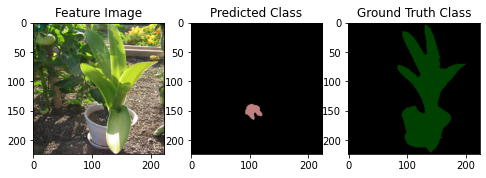

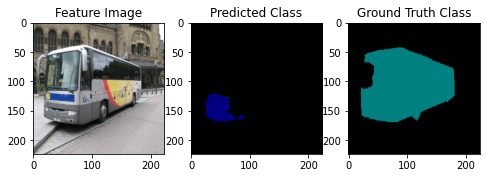

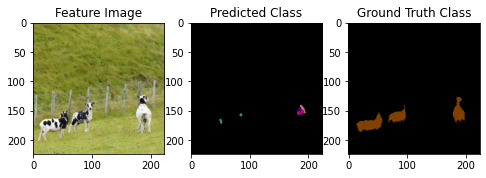

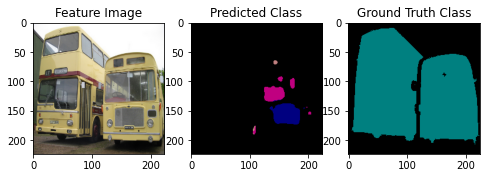

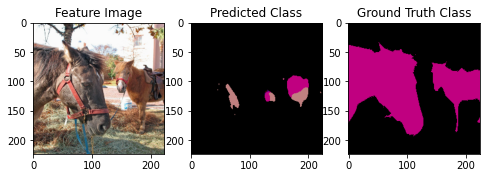

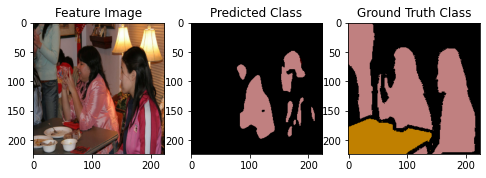

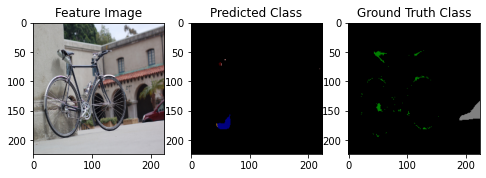

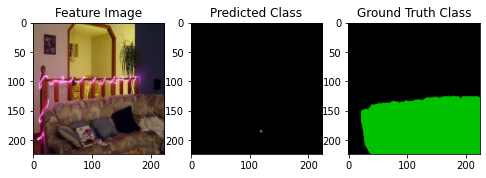

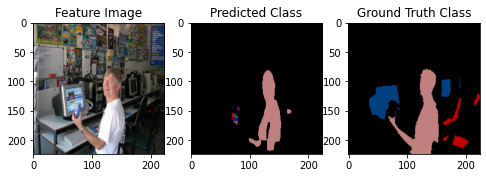

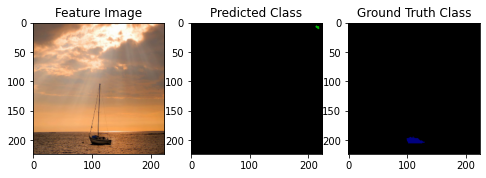

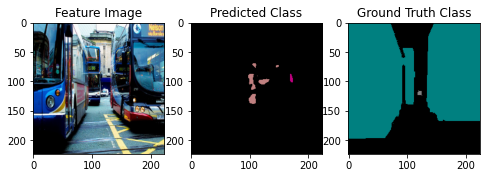

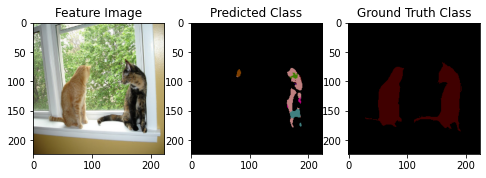

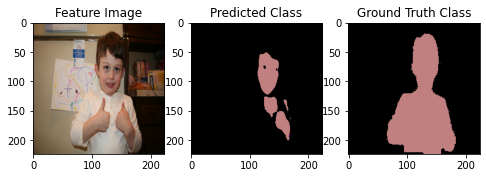

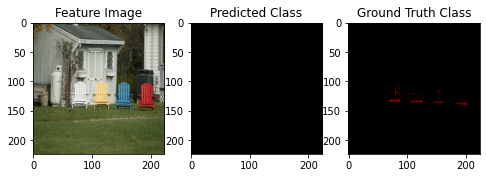

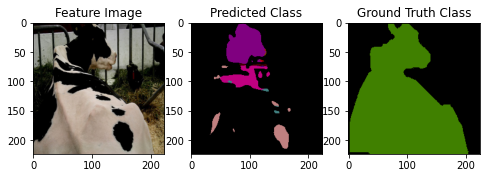

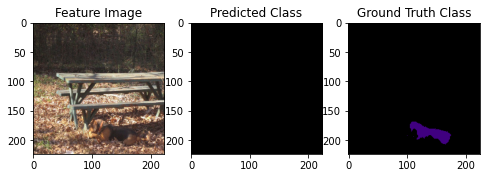

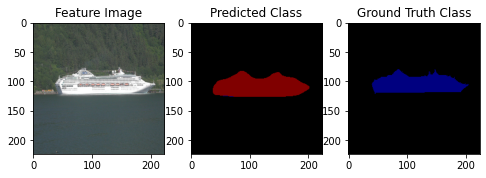

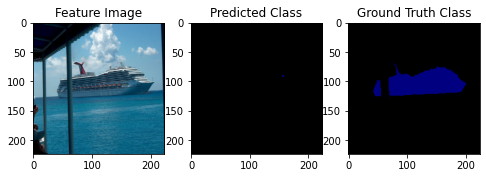

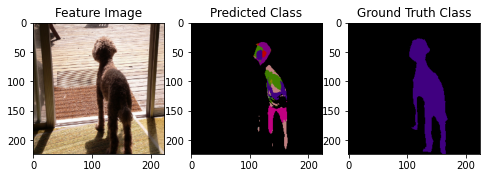

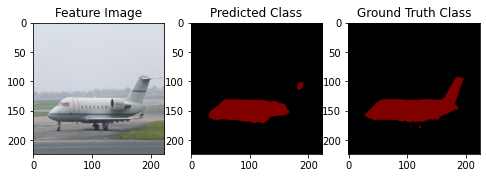

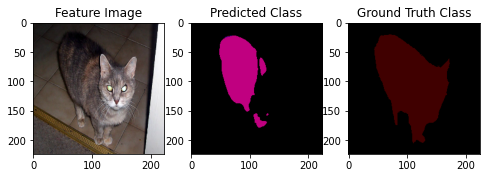

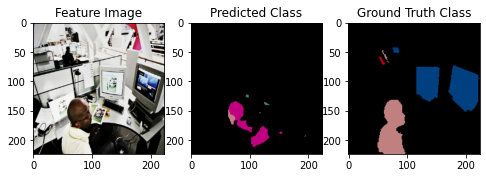

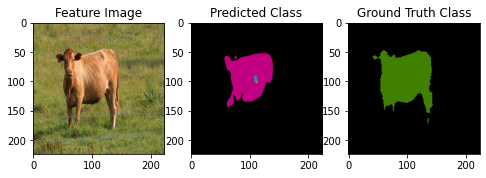

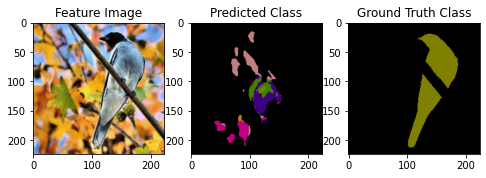

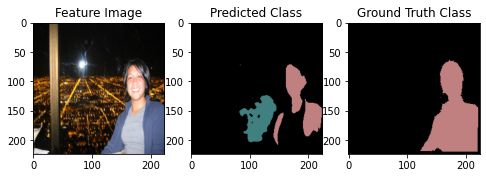

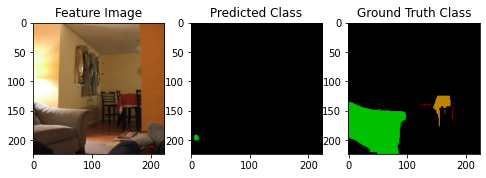

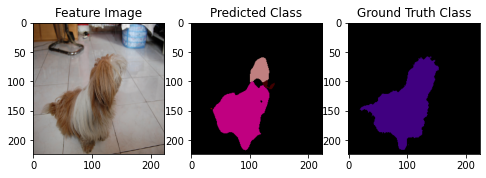

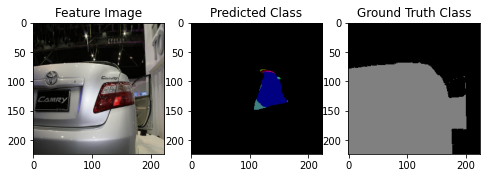

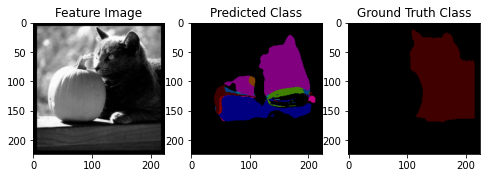

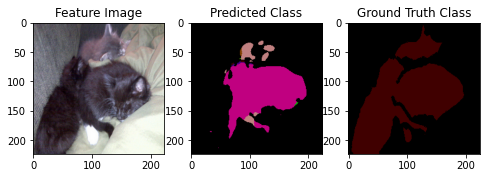

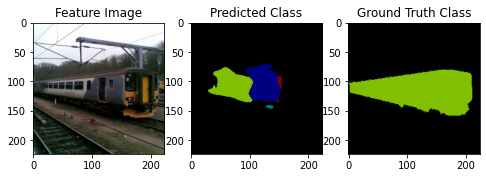

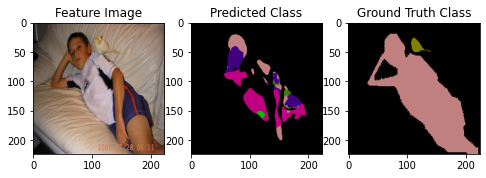

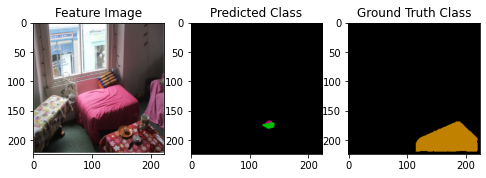

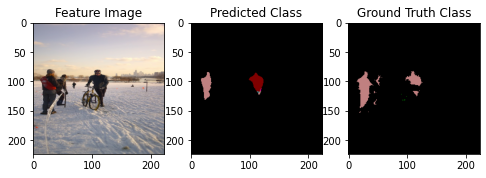

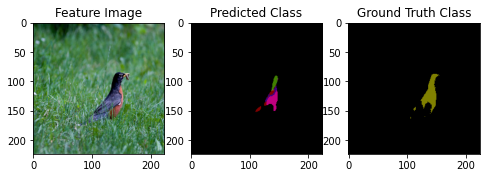

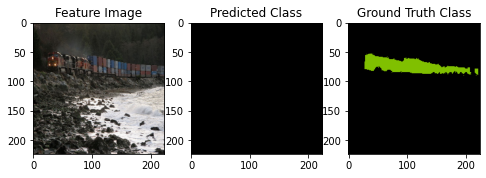

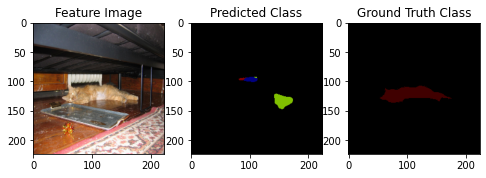

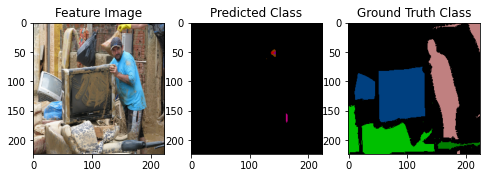

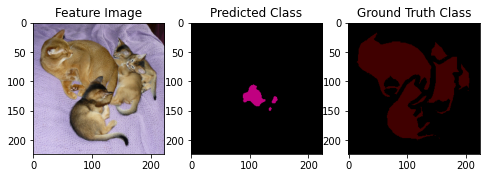

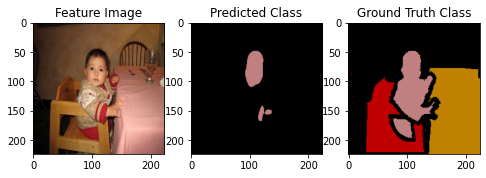

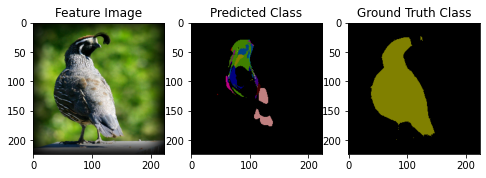

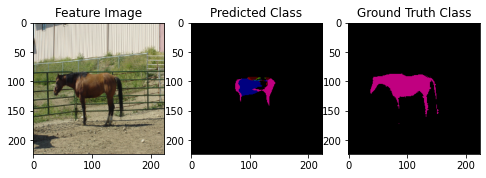

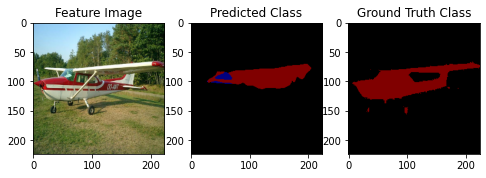

In [ ]:
for i in range(50):
    plot_seg_out_pairs(Xtest_seg[i], y_pred_seg_scratch_max[i], Ytest_seg[i])

###4.2.2 Semantic Segmentation using Transfer Learning

To improve the pefromance of the segmentation model, we train the model using transfer learning. Just like the tranfer learning in classification, here we use VGG16 model with imagenet weights. These weights are freezed on the network layer. The VGG16 corresponds to only the encoder part of the network. Therefore, we freeze the weights only to the encoder part.

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
def unet_upSamplingblock(filter,input,concat,concat_encoder):
    up_conv = BatchNormalization()(Conv2D(filters=filter,kernel_size=(2,2),activation='relu',padding='same',
                                          kernel_initializer='he_normal')(UpSampling2D(size=(2,2),interpolation='bilinear')(input)))
    if concat:
        merge = concatenate([concat_encoder,up_conv])
    else:
        merge = up_conv
    conv1 = BatchNormalization()(Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',
                                        kernel_initializer='he_normal')(merge))
    conv2 = BatchNormalization()(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same',
                                        kernel_initializer='he_normal')(conv1))

    return conv2


def unet(image_feature,vgg):
    conv1 = Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(image_feature)
    conv2 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    decoder_input = Dropout(0.5)(conv2)

    decoder1 = unet_upSamplingblock(filter=512,input=decoder_input,concat_encoder=vgg.get_layer('block5_conv3').output,concat=True)
    decoder2 = unet_upSamplingblock(filter=256,input=decoder1,concat_encoder=vgg.get_layer('block4_conv3').output,concat=True)
    decoder3 = unet_upSamplingblock(filter=128,input=decoder2,concat_encoder=vgg.get_layer('block3_conv2').output,concat=True)
    decoder4 = unet_upSamplingblock(filter=64,input=decoder3,concat_encoder=vgg.get_layer('block2_conv2').output,concat=True)
    decoder5 = unet_upSamplingblock(filter=64, input=decoder4, concat_encoder=vgg.get_layer('block1_conv2').output,concat=False)

    result = Conv2D(filters=n_classes,kernel_size=(1,1),activation='relu',padding='same',
                    kernel_initializer='he_normal',name='seg_output')(decoder5)

    return result

Here, we load the model with imagenet weights and freeze the network layers. It can be seen that in the model summary, the number of trainabe parameters are lesser comapred to the from the scratch model.

In [ ]:
vgg = VGG16(weights='imagenet',include_top = False,input_shape=(image_size,image_size,3))
for layer in vgg.layers:
    layer.trainable = False
image_feature = vgg.output
result = unet(image_feature,vgg)

unet_model_tl = Model(vgg.input, result)
unet_model_tl.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
unet_model_tl.compile(optimizer=keras.optimizers.Adam(lr=learning_rate_seg,decay=learning_rate_seg/EPOCHS_seg),loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
'''if os.path.isfile('Segmentation_TransferLearning_Weights.h5'):
  print("Weights File exits !!! \n Loading Weights to the model")
  unet_model_tl.load_weights('Segmentation_TransferLearning_Weights.h5')
else:
  print("Cannot find Wights !! Please re-upload the weights using the upload button in colab ")'''

'if os.path.isfile(\'Segmentation_TransferLearning_Weights.h5\'):\n  print("Weights File exits !!! \n Loading Weights to the model")\n  unet_model_tl.load_weights(\'Segmentation_TransferLearning_Weights.h5\')\nelse:\n  print("Cannot find Wights !! Please re-upload the weights using the upload button in colab ")'

We train the model with similar settings as that of the model from the scratch. The training parameters like loss and metrics during the training process is plotted below.

In [ ]:
seg_tl_model_history = unet_model_tl.fit(Xtrain_seg, Ytrain_seg, batch_size =  32, epochs = EPOCHS_seg, validation_split=(0.15), shuffle=True)


Train on 1146 samples, validate on 203 samples
Epoch 1/75
1146/1146 [==============================] - 118s 103ms/step - loss: 0.8621 - dice_coef: 0.1384 - val_loss: 0.9942 - val_dice_coef: 0.0055
Epoch 2/75
1146/1146 [==============================] - 99s 86ms/step - loss: 0.6125 - dice_coef: 0.3883 - val_loss: 0.9988 - val_dice_coef: 0.0012
Epoch 3/75
1146/1146 [==============================] - 98s 86ms/step - loss: 0.3213 - dice_coef: 0.6793 - val_loss: 0.9908 - val_dice_coef: 0.0094
Epoch 4/75
1146/1146 [==============================] - 98s 86ms/step - loss: 0.1875 - dice_coef: 0.8124 - val_loss: 0.9096 - val_dice_coef: 0.0934
Epoch 5/75
1146/1146 [==============================] - 98s 86ms/step - loss: 0.1547 - dice_coef: 0.8453 - val_loss: 0.6604 - val_dice_coef: 0.3467
Epoch 6/75
1146/1146 [==============================] - 98s 86ms/step - loss: 0.1416 - dice_coef: 0.8584 - val_loss: 0.4402 - val_dice_coef: 0.5626
Epoch 7/75
1146/1146 [==============================] - 98s 86m

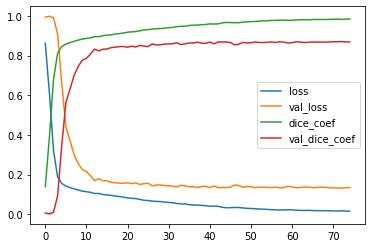

In [ ]:
for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:
    plt.plot(seg_tl_model_history.history[key],label=key)
plt.legend()
plt.show()

![seg 2](https://imgur.com/GTP2gzw)

In [ ]:
save_seg_tf_model_name = 'Segmentation_TransferLearning_Weights.h5'
unet_model_tl.save_weights('/content/gdrive/My Drive/'+save_seg_tf_model_name)

In [ ]:
y_pred_seg_tl = unet_model_tl.predict(Xtest_seg)
y_pred_seg_tl_max = np.argmax(y_pred_seg_tl, axis=3)

It can be seen that the model with tranfer learning obviously does a better job in segmenting the test sets. The **IOU** values are also higher comapred to the from the scratch model. The performance may not be so great but it is definitely better than the from the above from the scratch model. 

In [ ]:
IoU(Ytest_seg,y_pred_seg_tl_max)

class background:            #TP=5837313,            #FP=519300,            #FN=215152,            IoU=0.888
class aeroplane:            #TP= 13653,            #FP=  6877,            #FN= 5712,            IoU=0.520
class bicycle:            #TP=     0,            #FP=     8,            #FN= 1050,            IoU=0.000
class bird:            #TP= 23311,            #FP= 13084,            #FN=22233,            IoU=0.398
class boat:            #TP= 41763,            #FP= 34022,            #FN=12704,            IoU=0.472
class bottle:            #TP= 29467,            #FP= 22556,            #FN= 4235,            IoU=0.524
class bus:            #TP=122743,            #FP= 81547,            #FN=59100,            IoU=0.466
class car:            #TP= 22930,            #FP=  6212,            #FN=108495,            IoU=0.167
class cat:            #TP= 61217,            #FP= 44646,            #FN=67963,            IoU=0.352
class chair:            #TP=  1597,            #FP= 19264,            #FN=1

Some of the predicted segmentations for test set are plotted here. The RGB color palette mapping may be accurate for all the classes but it acceptable.

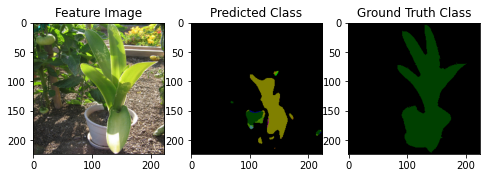

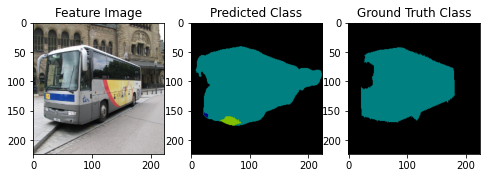

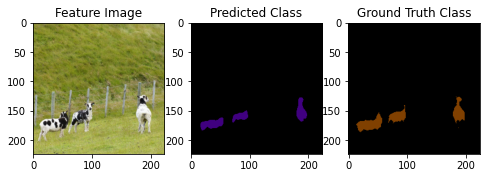

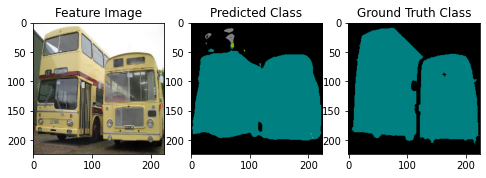

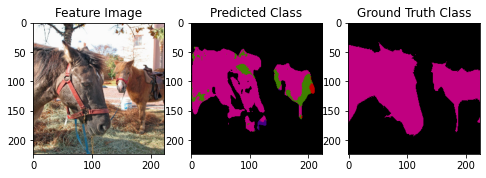

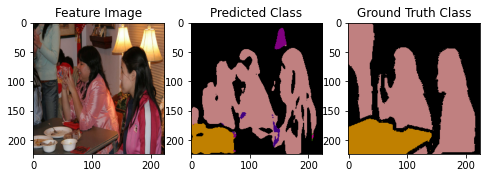

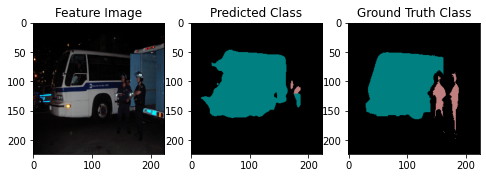

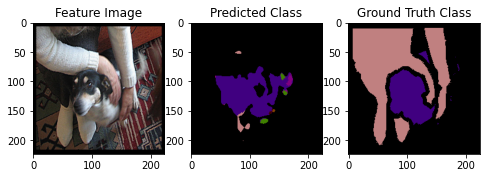

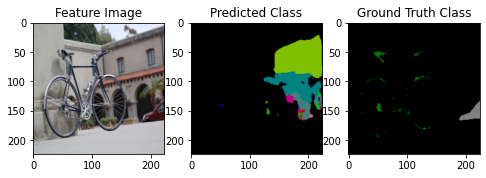

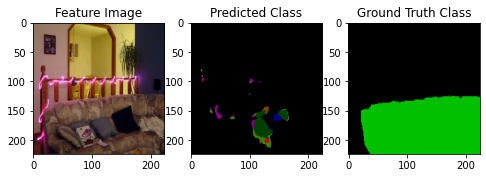

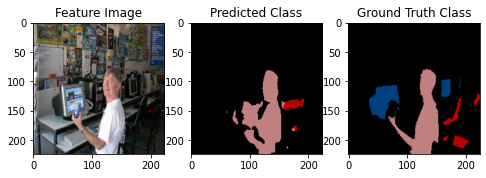

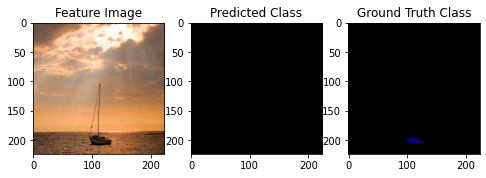

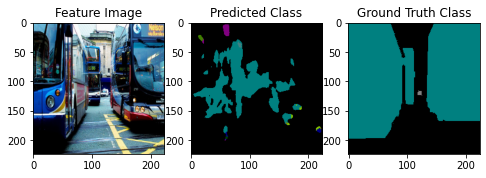

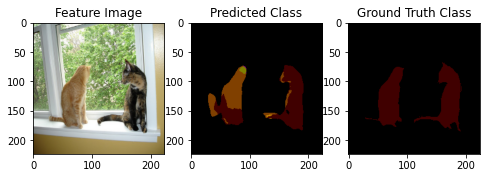

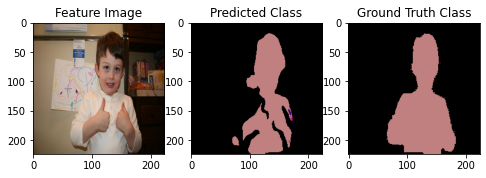

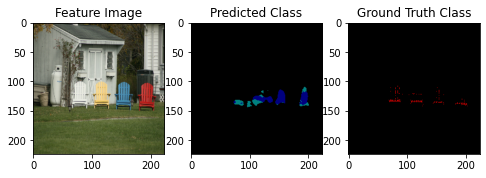

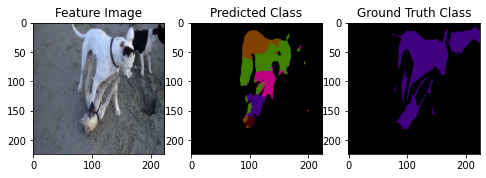

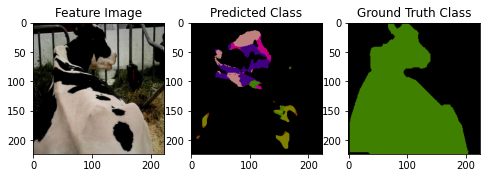

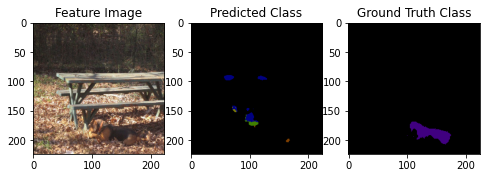

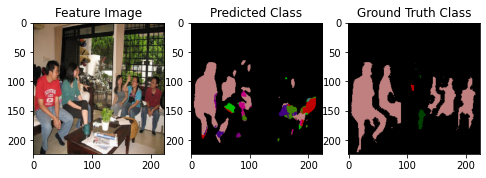

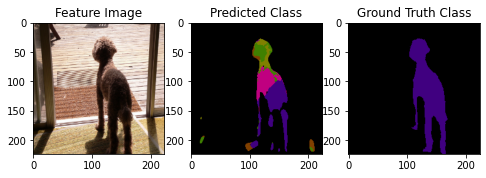

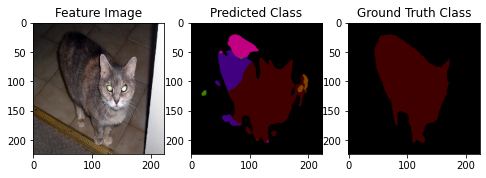

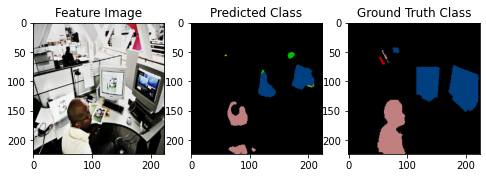

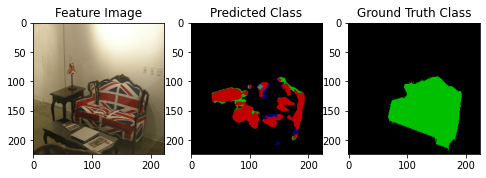

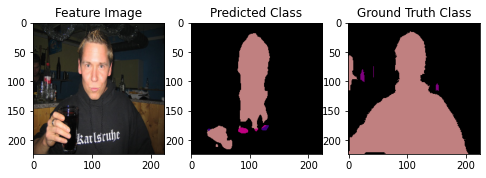

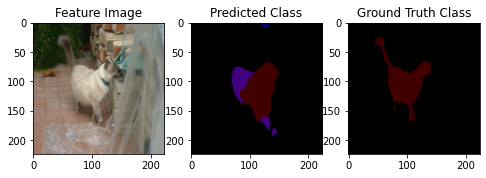

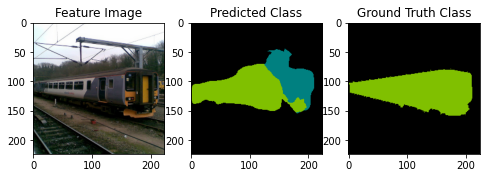

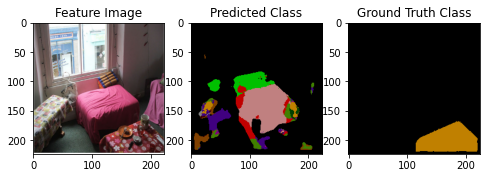

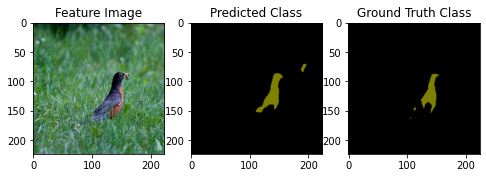

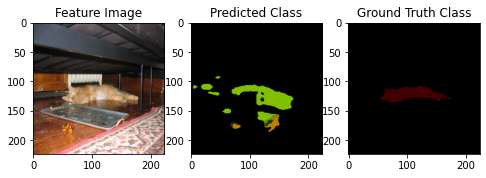

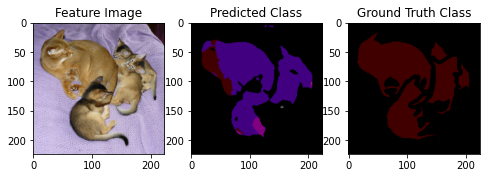

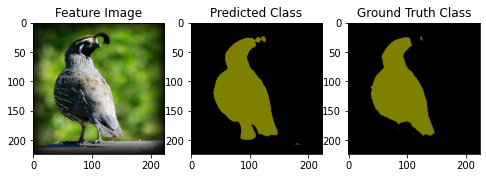

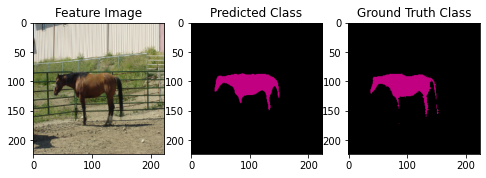

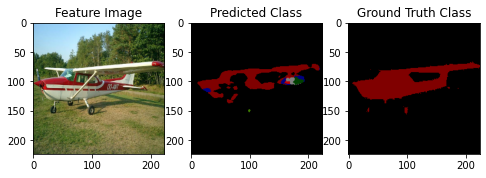

In [ ]:
for i in range(50):
    plot_seg_out_pairs(Xtest_seg[i], y_pred_seg_tl_max[i], Ytest_seg[i])

#5 Computer Vision - A solved problem ?

##5.1 Adversarial Examples

In this section, we develop an auto encoder model and train it with the train and test sets of classification data. The output of the adversarial model is then added to the original images and using this we perform an adversarial attack on the classifier.

In the below lines of code, we implement the auto-encoder model.

In [ ]:
def upsampling_conv(input,filter,model_name,kernel_size=(3,3),sample_size=(2,2),padding="same",activation="relu"):

    upsample = UpSampling2D(sample_size,name=model_name+'_Upsample')(input)
    conv_out = Conv2D(filter,kernel_size,name=model_name+"_Conv",padding=padding,activation=activation)(upsample)
    return conv_out


def maxpool_conv(input,filter,model_name,kernel_size=(3,3),pool_size=(2,2),padding="same",activation="relu"):
    conv_out = Conv2D(filter,kernel_size,name=model_name+"_Conv",padding=padding,activation=activation)(input)
    pool_out = MaxPooling2D(pool_size,name=model_name+"_Maxpooling")(conv_out)
    return pool_out

In [ ]:
def autoEncoderModel(input_height=224, input_width=224):
  input = Input(shape=(input_height,input_width,3))
  enc1= maxpool_conv(input,3,model_name="encoder_1")
  enc2= maxpool_conv(enc1,16,model_name="encoder_2")
  enc3= maxpool_conv(enc2,32,model_name="encoder_3")

  dec1 = upsampling_conv(enc3,32,model_name="decoder_1")
  dec2 = upsampling_conv(dec1,16,model_name="decoder_2")
  dec3 = upsampling_conv(dec2,3,model_name="decoder_3")

  adv_model = Model(input,dec3)

  return adv_model

In [ ]:
def get_img_idx(y_data):
  image_index = []
  for idx, data in  enumerate(y_data):
    for it, ele in enumerate(data):
      if ((it == 0 and ele == 1) or (it == 2 and ele == 1)):
        image_index.append(idx)

  return image_index


In [ ]:
trainIndex = get_img_idx(Ytrain_class)
testIndex = get_img_idx(Ytest_class)

In [ ]:
def get_adv_data(index,mode=None):
  x = []
  y = []
  if mode=='train':
    for idx in index:
      x.append(Xtrain_class[idx].tolist())
      y.append(Ytrain_class[idx].tolist())
  else:
    for idx in index:
      x.append(Xtest_class[idx].tolist())
      y.append(Ytest_class[idx].tolist())

  return np.array(x), np.array(y)

In [ ]:
Xtrain_adv, Ytrain_adv = get_adv_data(trainIndex, 'train')
Xtest_adv, Ytest_adv = get_adv_data(testIndex, 'test')


In [ ]:
print(Xtrain_adv.shape, Ytrain_adv.shape)
print(Xtest_adv.shape, Ytest_adv.shape)


(873, 224, 224, 3) (873, 20)
(148, 224, 224, 3) (148, 20)


In [ ]:
adversarial_model_train = autoEncoderModel(image_size,image_size)
adversarial_model_test = autoEncoderModel(image_size,image_size)


In [ ]:
 adversarial_model_train.compile(loss="mean_absolute_error",optimizer="adam",metrics=["accuracy"])
 adversarial_model_test.compile(loss="mean_absolute_error",optimizer="adam",metrics=["accuracy"])


**Training Adversiary 1: Train Adversiary** 

In [ ]:
adversarial_model_train.fit(x=Xtrain_adv,y=Xtrain_adv.copy(),batch_size=32,epochs=30,validation_split=0.15)

Train on 742 samples, validate on 131 samples
Epoch 1/30
742/742 [==============================] - 5s 7ms/step - loss: 0.2906 - accuracy: 0.3026 - val_loss: 0.2079 - val_accuracy: 0.1977
Epoch 2/30
742/742 [==============================] - 4s 5ms/step - loss: 0.1282 - accuracy: 0.3125 - val_loss: 0.1045 - val_accuracy: 0.4474
Epoch 3/30
742/742 [==============================] - 4s 5ms/step - loss: 0.0853 - accuracy: 0.4909 - val_loss: 0.0813 - val_accuracy: 0.5956
Epoch 4/30
742/742 [==============================] - 4s 5ms/step - loss: 0.0679 - accuracy: 0.5821 - val_loss: 0.0660 - val_accuracy: 0.6815
Epoch 5/30
742/742 [==============================] - 4s 5ms/step - loss: 0.0600 - accuracy: 0.6408 - val_loss: 0.0625 - val_accuracy: 0.6811
Epoch 6/30
742/742 [==============================] - 4s 5ms/step - loss: 0.0579 - accuracy: 0.6667 - val_loss: 0.0612 - val_accuracy: 0.7154
Epoch 7/30
742/742 [==============================] - 4s 5ms/step - loss: 0.0557 - accuracy: 0.7104 - 

**Training Adversiary 2: Test Adversiary** 

In [ ]:
adversarial_model_test.fit(x=Xtest_adv,y=Xtest_adv.copy(),batch_size=32,epochs=30,validation_split=0.15)


Train on 125 samples, validate on 23 samples
Epoch 1/30
125/125 [==============================] - 2s 14ms/step - loss: 0.4114 - accuracy: 0.2111 - val_loss: 0.3830 - val_accuracy: 0.3159
Epoch 2/30
125/125 [==============================] - 1s 5ms/step - loss: 0.3788 - accuracy: 0.2122 - val_loss: 0.3647 - val_accuracy: 0.3154
Epoch 3/30
125/125 [==============================] - 1s 5ms/step - loss: 0.3372 - accuracy: 0.2127 - val_loss: 0.2754 - val_accuracy: 0.3164
Epoch 4/30
125/125 [==============================] - 1s 5ms/step - loss: 0.2176 - accuracy: 0.2148 - val_loss: 0.1772 - val_accuracy: 0.3161
Epoch 5/30
125/125 [==============================] - 1s 5ms/step - loss: 0.1716 - accuracy: 0.3469 - val_loss: 0.1602 - val_accuracy: 0.3158
Epoch 6/30
125/125 [==============================] - 1s 5ms/step - loss: 0.1567 - accuracy: 0.4016 - val_loss: 0.1522 - val_accuracy: 0.3184
Epoch 7/30
125/125 [==============================] - 1s 5ms/step - loss: 0.1350 - accuracy: 0.4018 - 

Creating noise for adversiary 1

In [ ]:
trainnoise = adversarial_model_train.predict(Xtrain_adv)

In [ ]:
noiseFactor = 0.2
noiseFactorTest = 0.35

In [ ]:
Xtrain_adv_noise = Xtrain_adv+noiseFactor*trainnoise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Noised Image')

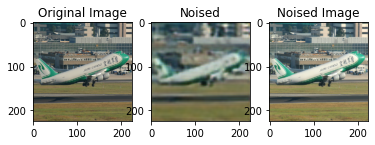

In [ ]:
plt.subplot(131)
plt.imshow(Xtrain_adv[10])
plt.title('Original Image')
plt.subplot(132)
plt.imshow(trainnoise[10])
plt.title('Noised')
plt.subplot(133)
plt.imshow(Xtrain_adv_noise[10])
plt.title('Noised Image')

As it can be seen that the noised image looks no different than original image and the noisy pertubrations is not visible to the human eyes

**Testing adversiary 1**

In [ ]:
scores_act = classifier_model_scratch.evaluate(Xtrain_adv,Ytrain_adv)
print("Actual Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[0], scores_act[0]*100))
print("Actual Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[1], scores_act[1]*100))
print("Actual Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[2], scores_act[2]*100))
print("Actual Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[3], scores_act[3]*100))

873/873 [==============================] - 9s 11ms/step
Actual Train set loss: 10.87%
Actual Train set accuracy: 97.42%
Actual Train set f1_m: 81.23%
Actual Train set precision_m: 72.32%


In [ ]:
scores_noise = classifier_model_scratch.evaluate(Xtrain_adv_noise,Ytrain_adv)
print("Noised Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[0], scores_noise[0]*100))
print("Noised Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[1], scores_noise[1]*100))
print("Noised Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[2], scores_noise[2]*100))
print("Noised Train set %s: %.2f%%" % (classifier_model_scratch.metrics_names[3], scores_noise[3]*100))

873/873 [==============================] - 8s 9ms/step
Noised Train set loss: 11.26%
Noised Train set accuracy: 97.11%
Noised Train set f1_m: 79.02%
Noised Train set precision_m: 70.11%


From the above evaluation it can be seen that our test results does not agree with what our eyes have seen. Because the number of true positive have reduce and false positive has increased as seen from f1 scores. Since we have used a low noise factor our classifier is fooled only by 1%. We can fool the classifier
to a great extent by increasing the noise factor.




**Creating noise for adversiary 2**

In [ ]:
testnnoise = adversarial_model_train.predict(Xtest_adv)
Xtest_adv_noise = Xtest_adv+noiseFactorTest*testnnoise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Noised Image')

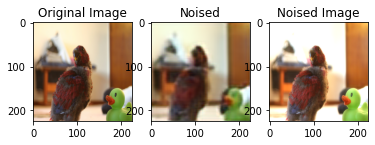

In [ ]:
plt.subplot(131)
plt.imshow(Xtest_adv[10])
plt.title('Original Image')
plt.subplot(132)
plt.imshow(testnnoise[10])
plt.title('Noised')
plt.subplot(133)
plt.imshow(Xtest_adv_noise[10])
plt.title('Noised Image')

**Testing adversiary 2**

In [ ]:
scores_act = classifier_model_scratch.evaluate(Xtest_adv,Ytest_adv)
print("Actual Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[0], scores_act[0]*100))
print("Actual Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[1], scores_act[1]*100))
print("Actual Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[2], scores_act[2]*100))
print("Actual Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[3], scores_act[3]*100))

148/148 [==============================] - 3s 23ms/step
Actual Test set loss: 20.95%
Actual Test set accuracy: 92.47%
Actual Test set f1_m: 52.17%
Actual Test set precision_m: 44.40%


In [ ]:
scores_noise = classifier_model_scratch.evaluate(Xtest_adv_noise,Ytest_adv)
print("Noise Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[0], scores_noise[0]*100))
print("Noise Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[1], scores_noise[1]*100))
print("Noise Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[2], scores_noise[2]*100))
print("Noise Test set %s: %.2f%%" % (classifier_model_scratch.metrics_names[3], scores_noise[3]*100))

148/148 [==============================] - 1s 10ms/step
Noise Test set loss: 21.88%
Noise Test set accuracy: 92.47%
Noise Test set f1_m: 50.51%
Noise Test set precision_m: 43.60%


From the above evaluation it can be seen that our test results on the test data does not agree with what our eyes have seen. Because the number of true positive have reduce and false positive has increased as seen from f1 scores. Since we have used a low noise factor our classifier is fooled only by 1%. We can fool the classifier
to a great extent by increasing the noise factor.

Provide a comparative analysis where you study the difference between the perturbations that were generated using the two different training sets, do you notice a difference in overall magnitude

We are able to fool the classifier even after using a low noise factor for train adversiary to a amount equivalent to the test adversiary although we are using higher noise factor. The reason is the number of samples in test adv is lesser

*    Do you notice a difference in how well the adversary can fool the model under attack?

  Since the classifier is performing well, with the current adversarial attack we are able to fool the model only by 1 %
  
*    Is this a realistic attack setup? Can it be used in a “real world” scenario
 If these kind of attack used in realistic schenario? 
 
 
 . eg, bank robbers , if they attempt a adversarial attack on safety camera based classifier that doesnot allow people with mask inside the bank. So although model works in ideal situatioon , it might fail and ease the way for dangerous crime. 
 *   Are the images still recognisable for a human
observer? Does this mean that your classifier hθc
from assignment 3.1 is now unreliable?
What could we do to increase the robustness of a model under attack in general?

The images are slightly recognisable by human eye , although the essense of image is not lost. Our classifier model was not trained to handle the adversarial attack. How ever we can fine tune the model by training the model by noisy images or testing the image after denoising it. No the classifier doesnot become completly unreliable as there is only slight reduce in performance , not complete irregularity in result. Also we do observe consistent alterations of the labels which would make the defense process easier.


#6 Summary and Conclusion


1.   **Take some time to reflect on what you have learned in the two assignments of this final project.**
 
 
 In the first assignment we learn how to train model to serve Multilabel Classification and semantic segmentation. We also learnt how to perform transfer learning on the two model using pretrained weights. Further we learn to test the robustness of classifier by tampering the dataset using advesarial attack.

2.**Did your classification and segmentation networks perform well?**


We  have seen the multilabel classification performs extreamly well .And the performance gets better for classification with transfer learning.
For sementation for simplicity we skipped to define the rgb code for shape boundaries. We get a poor performance when we train the segmentor from the scrach. However the accuracy increses significantly(both shape and RGB assignment) when trained with transfer-learning. 

3. **Has your adversary reached its goal?**

Since we see a significant reduce in accuracy of the model after the adversarial attack, although the sample images look similar to human eye, we succeeded in attacking the classifier via adversiary. 

4. **What would you do differently if you had some more time? Where would you spend your time on to improve your results?**


If given more time we would have augmented the data and trained the model for both classification and  segmentation . For segmentation I would have defined the RGB code for boundary in the colour pallete as it would have helped t restore better shape.  We could have tried to finetune the classifier in order to defend the advesary attacks. So we would have spend more time in designing a robust classifier capable of defending adversarial attacks.

5. **What are the limitations of your models?**


For segmentation model since we have not defined RGB code for boundary . we get distorted shape some times. We get poor performance for From the scrach segmentor

6. **What are the limitations of your models? Are they ready to be deployed in a
‘real world’ setting?**


Since we get bench mark performance for both classification and segmentation with transfer learning , I believe it can be deployed in real world setting

**Critical Analysis:** There is a massive data imbalance and the test data is not labelled, we cannot use the test data as training images. There is a huge over lap in the classes and therefore, it cannot give good results on multi-class classification. But, the data set can give good results on multi-label classification. 